In [ ]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import re
import sklearn

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib as matplot
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

Using TensorFlow backend.


In [ ]:
labels = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level']# subclass - > attack_type

train = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv')
test = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv')
train.columns , test.columns = labels , labels
combined_data = pd.concat([train, test]).drop('difficulty_level', 1)
# combined_data.shape
# combined_data.head(5)

### The following few cells are taken from the 'sample code'

In [ ]:
le = LabelEncoder()

vector = combined_data['attack_type']

print("Attack Vectors:", set(list(vector))) # use print to make it print on single line 
combined_data['attack_type'] = le.fit_transform(vector)
combined_data['protocol_type'] = le.fit_transform(combined_data['protocol_type'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['flag'] = le.fit_transform(combined_data['flag'])

print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==16)[0])/len(vector),"%")
print("looks like 16 is 'normal' ")

Attack Vectors: {'mscan', 'imap', 'apache2', 'saint', 'guess_passwd', 'ipsweep', 'normal', 'spy', 'teardrop', 'back', 'mailbomb', 'loadmodule', 'snmpgetattack', 'land', 'worm', 'perl', 'warezclient', 'ftp_write', 'udpstorm', 'portsweep', 'named', 'warezmaster', 'nmap', 'pod', 'rootkit', 'sqlattack', 'xlock', 'neptune', 'multihop', 'httptunnel', 'buffer_overflow', 'xterm', 'ps', 'snmpguess', 'sendmail', 'xsnoop', 'satan', 'phf', 'processtable', 'smurf'}

Describing attack_type: 
min apache2
max xterm
mode 0    normal
dtype: object
mode 0.0 %
looks like 16 is 'normal' 


# Reduce feature space - unused

In [ ]:
def RFS(): 
  # select least correlated
  corr_matrix = combined_data.corr().abs().sort_values('attack_type')
  # tmp.head(10) # to view CORR matrix 
  leastCorrelated = corr_matrix['attack_type'].where(lambda x: x < 0.005).dropna()
  leastCorrelated = list(leastCorrelated.index)

  # select least STD
  leastSTD = combined_data.std().to_frame().where(lambda x: x < 0.05).dropna()#.nsmallest(20, columns=0)
  leastSTD = list(leastSTD.transpose().columns)

  featureElimination = set(leastCorrelated + leastSTD)
  return featureElimination

# featureElimination = RFS()
# len(featureElimination)
# featureElimination




# Drop features and perform train_test_split

In [ ]:
# combined_data_reduced = combined_data.drop(featureElimination,axis=1)

data_x = combined_data.drop('attack_type', axis=1)
data_y = combined_data.loc[:,['attack_type']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.5, random_state=42) # TODO

X_train = pd.DataFrame(normalize(X_train))
X_test = pd.DataFrame(normalize(X_test)) # this is worng (cheating), i should have used a sk-learn obj. 

# Basline ML 

In [ ]:
import gc 
_ = gc.collect()
print("# of Dims, ",X_train.shape[1])

# of Dims,  41


In [ ]:
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
x = X_train
y = y_train['attack_type'].ravel()

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = clf.fit(x,y)
    pred = clf.score(X_test,y_test)
    print("Acc: %0.10f [%s]" % (pred,label))

# Comparison

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.svm import LinearSVC
n = 30 

In [ ]:
rfe = RFE(DTC, n).fit(x,y)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]


eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
_ = eclf.fit(X_train_RFE,y_train)
pred = eclf.score(X_test_RFE,y_test)

print("Acc: %0.10f" % (pred))
print("number of features",X_train_RFE.shape[1])

Acc: 0.9931723609
number of features 30


The above cell shows the tradeoff of garbagings the least useful features

In [ ]:
svd = TruncatedSVD(n_components=n-20) 
_ = svd.fit(X_train_RFE)  

X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
_ = eclf.fit(X_train_svd,y_train)

pred = eclf.score(X_test_svd,y_test)
print("Acc: %0.10f" % (pred))
print("number of features",X_train_svd.shape[1])

print(len(svd.components_) , "components,",len(svd.components_[0]), " length")

'''
Acc: 0.9921219548
number of features 20
----
Acc: 0.9851461815
number of features 10
'''

'\nAcc: 0.9921219548\nnumber of features 20\n----\nAcc: 0.9851461815\nnumber of features 10\n'

# Benchmark post feature reduction

In [ ]:
print(X_train_svd.shape)

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = eclf.fit(X_train_svd,y_train)
    pred = eclf.score(X_test_svd,y_test)
    print("Acc: %0.10f [%s]" % (pred,label))

(74257, 10)
Acc: 0.9861427206 [DecisionTreeClassifier]
Acc: 0.9858464522 [RandomForestClassifier]
Acc: 0.9860349866 [ExtraTreesClassifier]
Acc: 0.9862100543 [Ensemble]


0.985 for 10 dimensions of data

I like this better than 0.9937110306 with 41 features (dimension)

# Auto Encoder - not working 

In [ ]:
gc.collect()
print(X_train.shape)
print(X_test.shape)
# print(X_train_RFE.shape)
# print(X_test_RFE.shape)
# print(X_train_svd.shape) 
# print(X_test_svd.shape)

from sklearn.preprocessing import minmax_scale # 0.59 
from sklearn.preprocessing import StandardScaler # much beter 

144

(74257, 41)
(74257, 41)


In [ ]:
data_xx = data_x.copy()
data_xx = StandardScaler().fit_transform(data_xx)
X_train, X_test, y_train, y_test = train_test_split(data_xx, data_y, test_size=.5, random_state=42) # TODO

svd = TruncatedSVD(n_components=20).fit(X_train) 
X_train_svd, X_test_svd = svd.transform(X_train), svd.transform(X_test)

ss =StandardScaler()
X_train_svd= ss.fit_transform(X_train_svd)
X_test_svd = ss.transform(X_test_svd)

In [ ]:
#X_train.shape
pd.DataFrame(X_train_svd).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04
mean,-5.931994e-17,-4.786255e-17,-9.060360e-19,2.713436e-18,3.659279e-18,5.977221e-17,7.995842e-17,-5.523652e-17,-4.996542e-17,2.681067e-17,-5.501440e-18,5.245066e-17,-5.625721e-17,-3.385618e-17,4.463073e-18,-3.644328e-19,1.506920e-17,-1.786307e-17,-8.147689e-18,1.012936e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.326392e+00,-1.151137e+00,-2.413708e+00,-3.487665e+00,-2.104753e+00,-2.674641e+01,-8.434520e+00,-7.499560e+00,-8.542724e-01,-9.090700e+01,-2.041504e+01,-1.095229e+01,-1.408173e+01,-2.412788e+01,-3.065357e+01,-1.859074e+01,-7.435948e+00,-2.015774e+01,-2.596260e+01,-1.242226e+01
25%,-8.755797e-01,-3.913524e-01,-5.128250e-01,-1.767810e-01,-9.207745e-02,-1.930832e-01,-2.264271e-01,-2.968542e-01,-7.007081e-02,-9.728091e-02,-4.405853e-02,-2.080524e-01,-1.489525e-01,-1.581456e-01,-1.245313e-01,-5.241785e-01,-6.029555e-01,-2.893544e-01,-5.997300e-02,-5.361539e-01
50%,-5.020869e-01,-1.233750e-01,3.230989e-02,6.118126e-02,-3.726680e-02,-1.047378e-01,2.602396e-01,4.433327e-03,-2.832086e-02,-3.282730e-02,2.256744e-02,2.599542e-02,-3.707194e-02,-5.999457e-02,-1.571433e-02,6.781884e-02,-2.921378e-02,3.065591e-03,-6.431958e-03,3.913307e-02
75%,1.204626e+00,1.852484e-02,2.398357e-01,1.710523e-01,2.798611e-02,4.613763e-02,6.220538e-01,3.710084e-01,7.139207e-02,3.499273e-02,1.300525e-01,2.306683e-01,1.217623e-01,9.623254e-02,6.444027e-02,4.085296e-01,1.346024e-01,3.824667e-01,5.212486e-02,4.492619e-01
max,2.005726e+00,4.526969e+00,1.194687e+01,4.274254e+01,2.540734e+02,5.280319e+01,1.977229e+01,1.858820e+01,5.991677e+01,1.076784e+02,1.185268e+02,1.232672e+02,1.533263e+02,6.612642e+01,7.060549e+01,4.576437e+01,2.774570e+01,8.457870e+01,1.307231e+02,1.358720e+01


[source used](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)

In [ ]:
input_dim = X_train_svd.shape[1]
encoding_dim = 16
input_layer = Input(shape=(input_dim, ))

#encoder= BatchNormalization()(input_layer)
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [ ]:
# input_dim = X_train.shape[1]
# encoding_dim = 14

# input_layer = Input(shape=(input_dim, ))

# encoder = Dense(encoding_dim, activation="tanh", 
#                 activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

# decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

# autoencoder = Model(inputs=input_layer, outputs=decoder

In [ ]:
nb_epoch = 150
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', # mean_squared_error
                    metrics=['accuracy'])
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# from keras.utils import plot_model
# plot_model(autoencoder)

In [ ]:
history = autoencoder.fit(X_train_svd, X_train_svd,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_svd, X_test_svd),
                    verbose=1,
                    callbacks=[tensorboard]).history




Train on 74257 samples, validate on 74257 samples







Epoch 1/150
74257/74257 [==============================] - 10s 133us/step - loss: 0.8359 - acc: 0.6224 - val_loss: 0.8649 - val_acc: 0.7898

Epoch 2/150
74257/74257 [==============================] - 9s 121us/step - loss: 0.7598 - acc: 0.8207 - val_loss: 0.8271 - val_acc: 0.8317
Epoch 3/150
74257/74257 [==============================] - 9s 121us/step - loss: 0.7319 - acc: 0.8449 - val_loss: 0.7990 - val_acc: 0.8636
Epoch 4/150
74257/74257 [==============================] - 9s 120us/step - loss: 0.7097 - acc: 0.8763 - val_loss: 0.7803 - val_acc: 0.8718
Epoch 5/150
74257/74257 [==============================] - 9s 121us/step - loss: 0.6983 - acc: 0.8818 - val_loss: 0.7663 - val_acc: 0.8892
Epoch 6/150
74257/74257 [==============================] - 9s 122us/step - loss: 0.6897 - acc: 0.8834 - val_loss: 0.7563 - val_acc: 0.8926
Epoch 7/150
74257/74257 [==============================] - 9s 121us/step - loss: 0.6822 - acc: 0.8849 - 

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

NameError: ignored

In [ ]:
predictions = autoencoder.predict(X_test_svd)
mse = np.mean(np.power(X_test_svd - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
error_df.describe()

,reconstruction_error,true_class
count,74257.000000,74257.000000
mean,0.585880,15.768951
std,14.078053,4.521670
min,0.023231,0.000000
25%,0.090252,14.000000
50%,0.116053,16.000000
75%,0.268303,16.000000
max,1783.029915,39.000000


In [ ]:
autoencoder.evaluate(X_test_svd,X_test_svd)

74257/74257 [==============================] - 2s 27us/step


[0.5894532675636395, 0.9032145117648062]

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
# _ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# fraud_error_df = error_df[error_df['true_class'] == 1]
# _ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

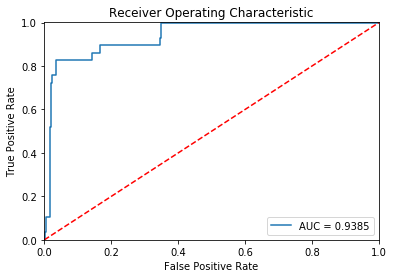

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=2)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

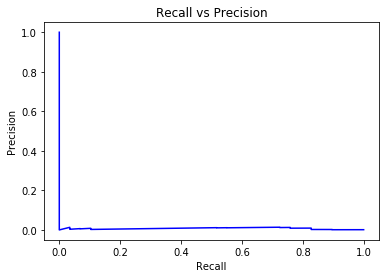

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=2)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [8]:
import pandas as pd
import pickle
v1=3
v2=4
v3=5

df1= pd.DataFrame({'v1': 3, 'v2': 4}, index=[0])
print(df1)

   v1  v2
0   3   4


In [33]:
# Custom modules
from data_prep import load_csv_data
import model_abstraction as moda

# Data Structures
import pandas as pd
import numpy as np

# Preprocessing or data manipulation methods
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# Modeling methods and selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import OneClassSVM, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Model assessment
from sklearn.metrics import confusion_matrix, roc_auc_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
def transform_labels(labels):
    labels1 = []
    for val in labels:
        if val == 'anomaly':
            labels1.append(1)
        else:
            labels1.append(0)
    return labels1
#X_train, y_train = load_csv_data('/content/UNSW_training_30_63.csv')
data1 = pd.read_csv('/content/KDD_training_30_50.csv',header=0, index_col=0)

features1 = data1.select_dtypes(exclude='object').iloc[:,:-1]


X_train=features1
print('X_train', features1)
print('X_train length', len(features1))

y_train=data1.label
print('y_train', y_train)
print('y_train length', len(features1))


y_train=transform_labels(y_train)
		
data2 = pd.read_csv('/content/KDD_testing_30_10.csv',header=0, index_col=0)

features2 = data2.select_dtypes(exclude='object').iloc[:,:-1]
X_test=features2
y_test=data2.label

y_test=transform_labels(y_test)


gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)


print('X test length',len(X_test))
print('y test length',len(y_test))

y_pred=gbc.predict(X_test)
print('y pred length',len(y_pred))
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy for Gradient Boost:",metrics.accuracy_score(y_test, y_pred))

lgr = LogisticRegression(solver = 'liblinear', penalty = 'l1', random_state=42)
lgr.fit(X_train, y_train)
y_pred=lgr.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy for lgr:",metrics.accuracy_score(y_test, y_pred))

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy for Knn:",metrics.accuracy_score(y_test, y_pred))

from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets
#model.fit(features,label)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy for Gaussian NB:",metrics.accuracy_score(y_test, y_pred))

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy for Decision Tree:",metrics.accuracy_score(y_test, y_pred))




X_train           src_bytes  dst_bytes  ...  dst_host_srv_serror_rate  dst_host_rerror_rate
duration                        ...                                                
0                 0          0  ...                      1.00                  0.00
0                 0          0  ...                      0.00                  0.95
0                 0          0  ...                      1.00                  0.00
0                 0         15  ...                      0.00                  1.00
0                 0          0  ...                      1.00                  0.00
...             ...        ...  ...                       ...                   ...
0               145      13852  ...                      0.00                  0.00
0               207       5200  ...                      0.00                  0.00
0                35        130  ...                      0.00                  0.00
0               383          0  ...                      0.01       

In [45]:
# Custom modules
from data_prep import load_csv_data
import model_abstraction as moda

# Data Structures
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
# Preprocessing or data manipulation methods
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# Modeling methods and selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import OneClassSVM, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Model assessment
from sklearn.metrics import confusion_matrix, roc_auc_score

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt



def show_auc(labels, t1, t2):
    return roc_auc_score(labels, t1, multi_class='ovr'), roc_auc_score(labels, t2, multi_class='ovr')

def transform_labels(labels):
    labels1 = []
    for val in labels:
        if val == 'anomaly':
            labels1.append(1)
        else:
            labels1.append(0)
    return labels1
#X_train, y_train = load_csv_data('/content/UNSW_training_30_63.csv')
data1 = pd.read_csv('/content/KDD_training_30_50.csv',header=0, index_col=0)

features1 = data1.select_dtypes(exclude='object').iloc[:,:-1]


X_train=features1
print('X_train', features1)
print('X_train length', len(features1))

y_train=data1.label
print('y_train', y_train)
print('y_train length', len(features1))


y_train=transform_labels(y_train)


clf1 = IsolationForest(random_state=0).fit(X_train)
clf2 = OneClassSVM(gamma='auto').fit(X_train)

#data2 = pd.read_csv('/content/KDD_testing_30_50.csv',header=0, index_col=0)

#features2 = data2.select_dtypes(exclude='object').iloc[:,:-1]
#X_test=features2
#y_test=data2.label

#y_test=transform_labels(y_test)


# Test data
data2 = pd.read_csv('/content/KDD_testing_30_50.csv',header=0, index_col=0)

Y=data2.select_dtypes(exclude='object').iloc[:,:-1]
print("Y", Y)
print("y length", len(Y))
#Y = Y.replace([np.inf, -np.inf], np.nan)
# Drop all occurences of NaN
#Y = Y.dropna()
# Double check these are all gone
#print("CHecking Y",Y.isnull().any().any())
Y = Y.to_numpy()
#labels = list(Y1[:, -1])
#labels = transform_labels(labels)
labels=transform_labels(data2.label)
#labels[0] = -1
#print (labels)
#Y = pd.read_csv('/content/KDD_testing_30_50.csv')
#Y=Y.select_dtypes(exclude='object').iloc[:,:-1]

#Y = Y[:, :-1]


#Y[Y == 'anomaly'] = 1
#print ('Test shape. ', np.shape(Y))

t1, t2 = [], []

#t1 = []
for i in range(np.shape(Y)[0]):
    test_data = [float(val) for val in Y[i, :]]
    # print (test_data)
    #print ('Data point ', str(i))

    t1.append(clf1.predict([test_data])[0])
    t2.append(clf2.predict([test_data])[0])

#print (t1, t2)
#print (t1)
print (show_auc(labels, t1,t2))


X_train           src_bytes  dst_bytes  ...  dst_host_srv_serror_rate  dst_host_rerror_rate
duration                        ...                                                
0                 0          0  ...                      1.00                  0.00
0                 0          0  ...                      0.00                  0.95
0                 0          0  ...                      1.00                  0.00
0                 0         15  ...                      0.00                  1.00
0                 0          0  ...                      1.00                  0.00
...             ...        ...  ...                       ...                   ...
0               145      13852  ...                      0.00                  0.00
0               207       5200  ...                      0.00                  0.00
0                35        130  ...                      0.00                  0.00
0               383          0  ...                      0.01       

In [25]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score
X = pd.read_csv('/content/KDD_training_30_50.csv')
# Replace Inf values with NaN
#X = X.replace([np.inf, -np.inf], np.nan)
# Drop all occurences of NaN
#X = X.dropna()
# Double check these are all gone
#print("Checking X",X.isnull().any().any())
#X=X.dropna(inplace=True)
def transform_labels(labels):
    labels1 = []
    for val in labels:
        if val == 'anomaly':
            labels1.append(1)
        else:
            labels1.append(0)
    return labels1
y_train=X.label
y_train=transform_labels(y_train)

#features = list(X.keys())[:-1]
# print (len(features))

X = X.to_numpy()
X = X[:, :-1]

# print (X)
# print (np.shape(X))


clf1 = IsolationForest(random_state=0).fit(X)
#clf2 = OneClassSVM(gamma='auto').fit(X)

# Test data
Y = pd.read_csv('/content/KDD_training_30_50.csv')
#Y = Y.replace([np.inf, -np.inf], np.nan)
# Drop all occurences of NaN
#Y = Y.dropna()
# Double check these are all gone
#print("CHecking Y",Y.isnull().any().any())
Y = Y.to_numpy()
labels = list(Y[:, -1])
labels = transform_labels(labels)
#labels[0] = -1
#print (labels)

Y = Y[:, :-1]


Y[Y == 'anomaly'] = 1
#print ('Test shape. ', np.shape(Y))

#t1, t2 = [], []

t1 = []
for i in range(np.shape(Y)[0]):
    test_data = [float(val) for val in Y[i, :]]
    # print (test_data)
    print ('Data point ', str(i))

    t1.append(clf1.predict([test_data])[0])
    #t2.append(clf2.predict([test_data])[0])

#print (t1, t2)
print (t1)
print (show_auc(labels, t1))

ValueError: ignored